In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from mlflow import MlflowClient
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
client = MlflowClient(tracking_uri="sqlite:////mnt/stud/home/mwirth/projects/al-embeddings/output/mlflow.db")

In [12]:
names = ["Reuters", "AAPD"]
init_stats = ["random"]
models = ["BertBaseUncased"]
missing = []
params_map = {
    "dataset.name": ("dataset", str),
    "al.query_strategy.name": ("query_strat", str),
    "dataset.batch_size": ("batch_size", int),
    "al.n_cycles": ("n_cycles", int),
    "embeddings.network": ("embed", str),
    #"classifier.estimator": ("clf", str),
    #"al.init_strategy.name": ("init_stat", str),
    "random_seed": ("seed", int),
}

all_run_data = []
for init_stat in init_stats:
    for name in names:
        for model in models:
            exp_name = f"{name}-{init_stat}-{model}"
            exp = client.get_experiment_by_name(exp_name)
            if exp is None:
                missing.append(exp_name)
                continue
            runs = client.search_runs(experiment_ids=exp.experiment_id, order_by=["attribute.start_time DESC"])

            for run in runs:
                run_data = {
                    "name": exp_name,
                    "run_id": run.info.run_id,
                    "status": run.info.status,
                }
                for param_name, (name, typ) in params_map.items():
                    run_data[name] = typ(run.data.params[param_name])
                if run_data["status"] == "FINISHED":
                    all_run_data.append(run_data)
print(f"Found: {len(all_run_data)}")

Found: 66


In [20]:
df = pd.DataFrame(all_run_data)
# These are the important parameters
match_params = {
    "query_strat": ['ProbCover', 'TypiClust', 'MMC', 'Random', 'LCI', 'Badge', 'Entropy', 'DropQuery', 'CoreSet', 'margin', "LC"],
    "seed": [1, 2, 3],
    "embed": ["BertBaseUncased"],
    "dataset": names
}
all_combinations = list(product(*match_params.values()))
print("Expected number of runs: ", len(all_combinations))

mask = pd.Series(True, index=df.index) # Start with a mask where all rows are True

for param_key, allowed_values in match_params.items():
    if param_key in df.columns:
        mask = mask & df[param_key].isin(allowed_values)

df_filtered = df[mask].copy()
print("Found:", len(df_filtered), "/", len(all_combinations))
found_combinations = set(df_filtered[match_params.keys()].apply(tuple, axis=1).tolist())
missing_combinations = [combo for combo in all_combinations if combo not in found_combinations]
print("Missing:")
missing_combinations

Expected number of runs:  66
Found: 66 / 66
Missing:


[('Badge', 1, 'BertBaseUncased', 'AAPD'),
 ('Badge', 2, 'BertBaseUncased', 'AAPD'),
 ('Badge', 3, 'BertBaseUncased', 'AAPD')]

In [21]:
metrics = ["accuracy", "top_1_accuracy", "cMAP"]
exp_data = []
for idx, run in df_filtered.iterrows():
    hists = []
    for metric in metrics:
        hist = client.get_metric_history(run_id=run["run_id"], key=metric)
        hist = [v.value for v in hist]
        hists.append(hist)

    aqu_list = range(0, run["n_cycles"] + 1)
    for metric_values, batch_size in zip(zip(*hists), aqu_list):
        run_data = run.to_dict()
        metric_dict = dict(zip(metrics + ["step"], metric_values + (batch_size,)))
        run_data.update(metric_dict)
        #exp_data.append(run)
        exp_data.append(run_data)
        #print(run_data)

In [22]:
df_runs = pd.DataFrame(exp_data)
means = df_runs.groupby(["name", "embed", "dataset", "query_strat", "batch_size", "step"])[metrics].mean()
stds = df_runs.groupby(["name", "embed","dataset", "query_strat", "batch_size", "step"])[metrics].std()

In [23]:
models = [] or means.index.get_level_values("embed").unique()
datasets = [] or means.index.get_level_values("dataset").unique()
query_strats = [] or means.index.get_level_values("query_strat").unique()
metric = "cMAP"

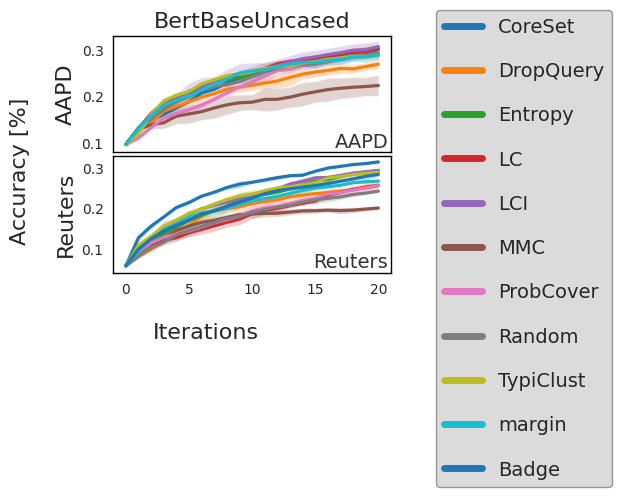

In [24]:
fig, axes = plt.subplots(len(datasets), len(models), figsize=(len(models) * 4, len(datasets) * 1.75), sharex="col", #sharey="row", #tight_layout=True
)
if len(axes.shape) != 2:
    axes = axes[:, np.newaxis]
for d, (axe, dataset) in enumerate(zip(axes, datasets)):
    for m, (ax, model) in enumerate(zip(axe, models)):
        # ax.tick_params(axis='x', which='both', top=False)
        # ax.tick_params(axis='y', which='both', right=False)
        if d == 0:
            ax.set_title(model, fontsize=16)

        if d == len(datasets) - 1:
            #ax.set_xlabel("Iterations", fontsize=14)
            ax.set_xticks(np.arange(0, 20+1, 5.0))

        if m == 0:
            ax.set_ylabel(dataset.replace("_scape", ""), fontsize=16)
            #ax.set_ylabel("Accuracy [%]", fontsize=14)


        #ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.text(0.99, 0.01, dataset.replace("_scape", ""),
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes, # This makes the coordinates relative to the axes
            fontsize=14, # Adjust size as needed
            color='black', # Make it subtle
            alpha=0.8,) # Add some transparency for less visual clutter
        [i.set_linewidth(1) for i in ax.spines.values()]
        [i.set_color("k") for i in ax.spines.values()]
        ax.grid()

        for strategy in query_strats:
            mean = means.xs((model, dataset, strategy), level=(1,2,3))[metric].squeeze()
            std = stds.xs((model, dataset, strategy), level=(1,2,3))[metric].squeeze()
            x_axis = mean.index.get_level_values(-1)

            ax.plot(x_axis, mean, label=strategy, linewidth=2.3)
            ax.fill_between(x_axis, mean-std, mean+std, alpha=0.25)

leg = fig.legend(*axes[0][0].get_legend_handles_labels(), loc="upper left", bbox_to_anchor=(1.05, 0.99), ncol=1, fontsize=14, frameon=True, labelspacing=1.3)
frame = leg.get_frame()
frame.set_facecolor('lightgrey')
frame.set_edgecolor('grey')

for line, name in zip(leg.get_lines(), leg.get_texts()):
    line.set_linewidth(5)
fig.supylabel("Accuracy [%]", x=0.01, fontsize=16)
fig.supxlabel("Iterations", y=0.01, fontsize=16)
fig.tight_layout()
fig.subplots_adjust(hspace=0.03, wspace=0.25)


In [25]:
def calculate_pairwise_winrates(df, metric_name):
    """
    Calculates pairwise winrates between strategies for a specific init_strategy,
    comparing at the level of dataset, model, step, and seed.

    Args:
        df (pd.DataFrame): The input DataFrame with columns ['dataset',
                           'strategy', 'init_strategy', 'model', 'step',
                           'seed', 'Accuracy'].
        target_init_strategy (str): The specific init_strategy to filter by.

    Returns:
        pd.DataFrame: A DataFrame showing pairwise comparison results
                      (Wins A, Wins B, Draws, Total Comparisons, Winrate A vs B)
                      for strategies within the target_init_strategy.
                      Returns an empty DataFrame if no data matches
                      the target_init_strategy.
    """
    # 1. Filter the DataFrame by the target init_strategy
    df_filtered = df.copy().round(3)
    df_filtered = df_filtered[df_filtered["step"] != 0]

    unique_strategies = df_filtered['query_strat'].unique()
    results = []

    # 2. Iterate through all unique pairs of strategies (A vs B)
    # We calculate both A vs B and B vs A
    for s1 in unique_strategies:
        for s2 in unique_strategies:
            if s1 == s2:
                results.append({
                    'Strategy A': s1,
                    'Strategy B': s2,
                    'Wins A': 0,
                    'Wins B': 0,
                    'Draws': 0,
                    'Total Comparisons': 0,
                    'Winrate A vs B': 0.0
                })
                continue # Skip self-comparison

            # Select data for strategy s1 and s2
            df_s1 = df_filtered[df_filtered['query_strat'] == s1].reset_index(drop=True)
            df_s2 = df_filtered[df_filtered['query_strat'] == s2].reset_index(drop=True)

            # 3. Merge data on the comparison keys to align entries
            # Use an inner join to only compare instances where both strategies exist
            merged_df = pd.merge(
                df_s1,
                df_s2,
                on=['dataset', 'embed', 'step', 'seed'],
                suffixes=(f'_{s1}', f'_{s2}'), # Use strategy names as suffixes
                how='inner'
            )

            # Handle potential issues with special characters in strategy names for column access
            accuracy_col_s1 = f'metric_{s1}'
            accuracy_col_s2 = f'metric_{s2}'

            # Ensure columns exist after merge (should if suffixes worked)
            if accuracy_col_s1 not in merged_df.columns or accuracy_col_s2 not in merged_df.columns:
                 # Fallback to standard suffixes if custom suffixes fail
                 merged_df = pd.merge(
                     df_s1,
                     df_s2,
                     on=['dataset', 'embed', 'step', 'seed'],
                     suffixes=('_A', '_B'),
                     how='inner'
                 )
                 accuracy_col_s1 = f'{metric_name}_A'
                 accuracy_col_s2 = f'{metric_name}_B'


            # 4. Calculate wins, losses, and draws for the current pair
            wins_s1 = (merged_df[accuracy_col_s1] > merged_df[accuracy_col_s2]).sum()
            wins_s2 = (merged_df[accuracy_col_s2] > merged_df[accuracy_col_s1]).sum()
            draws = (merged_df[accuracy_col_s1] == merged_df[accuracy_col_s2]).sum()
            total_comparisons = len(merged_df)

            # 5. Calculate winrate (handle division by zero)
            winrate_s1_vs_s2 = wins_s1 / total_comparisons if total_comparisons > 0 else 0.0

            # Append results for this pair
            results.append({
                'Strategy A': s1,
                'Strategy B': s2,
                'Wins A': wins_s1,
                'Wins B': wins_s2,
                'Draws': draws,
                'Total Comparisons': total_comparisons,
                'Winrate A vs B': winrate_s1_vs_s2
            })

    # 6. Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df

def plot_winrate_matrix(winrate_df):
    """
    Plots the pairwise winrate matrix as a heatmap, including a mean winrate column.

    Args:
        winrate_df (pd.DataFrame): DataFrame containing pairwise winrates,
                                   output from calculate_pairwise_winrates.
        init_strategy (str): The init_strategy used for calculation (for title).
        strategies (list, optional): A list of strategies to define the order
                                     on the axes. If None, order is derived
                                     from the data.
    """
    if winrate_df.empty:
        print("No winrate data to plot.")
        return

    # Pivot the DataFrame to get the matrix format
    # Rows are Strategy A, Columns are Strategy B, Values are Winrate A vs B
    winrate_matrix = winrate_df.pivot(
        index='Strategy A',
        columns='Strategy B',
        values='Winrate A vs B'
    )

    strategy_cols = winrate_matrix.columns.tolist()
    mean_winrates = winrate_matrix.mean(axis=1) #/ len(strategy_cols)

    # Add the mean winrate as a new column to the winrate_matrix
    winrate_matrix['Mean'] = mean_winrates

    mean_col_index = winrate_matrix.columns.get_loc('Mean')
    winrate_matrix.insert(loc=mean_col_index, column=' ', value=np.nan)

    ordered_strategy_cols = [s for s in query_strats if s in strategy_cols]
    final_col_order = ordered_strategy_cols + [' ', 'Mean']

    # Determine the desired row order (reversed strategies)
    ordered_rows = [s for s in query_strats[::-1] if s in winrate_matrix.index]

    # Reindex the DataFrame
    winrate_matrix = winrate_matrix.reindex(index=ordered_rows, columns=final_col_order)

    # Capitalize names for display on the plot
    # winrate_matrix = winrate_matrix.rename(
    #     columns={k: k.capitalize() for k in winrate_matrix.columns},
    #     index={k: k.capitalize() for k in winrate_matrix.index}
    # )

    plt.figure(figsize=(6, 5.5))
    ax = sns.heatmap(
        winrate_matrix, # Plot the matrix with the new column
        annot=True,     # Annotate cells with the winrate values
        fmt=".2f",      # Format the annotations to 2 decimal places
        cmap="coolwarm", # Color map
        cbar=False,       # Show color bar (might need adjustment if mean scale differs)
        square=True
    )

    plt.xlabel('Opponent Strategy')
    plt.ylabel('Strategy')

    plt.tight_layout() # Adjust layout
    plt.grid(False)
    ax.tick_params(length=0, which="both")

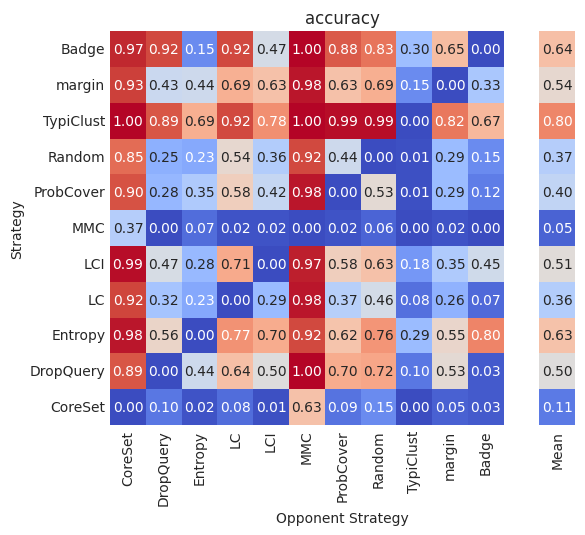

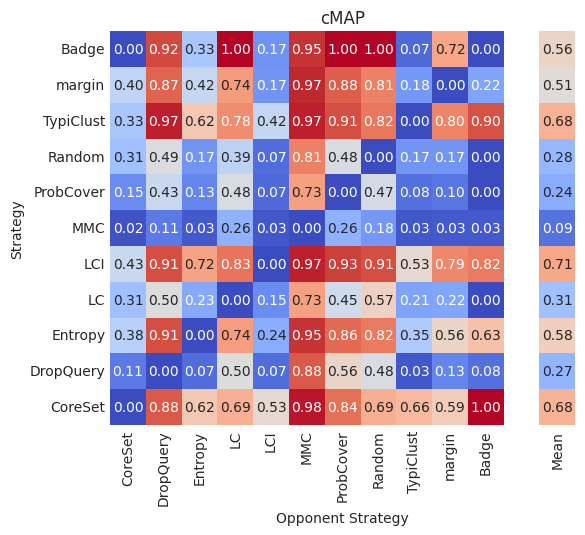

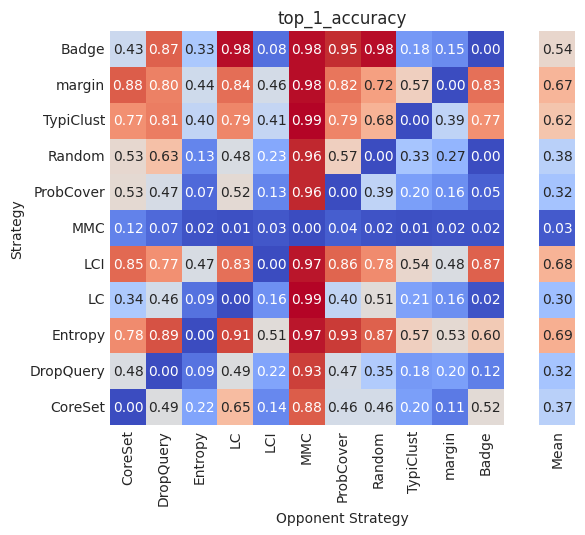

In [26]:
for n in ["accuracy", "cMAP", "top_1_accuracy"]:
    win_rates_df = calculate_pairwise_winrates(df_runs, n)
    plot_winrate_matrix(win_rates_df)
    plt.title(n)
#plt.savefig("plots/pairwise_winrate_random.pdf", dpi=300)